Open Data Science Course, topic 9: Time series

## Imports  

In [4]:
# Vectors, matrices, data manipulation, tables and plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
# Statistics, econometrics
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
# Function minimization for dates
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
# Nice progressbar and ..
from itertools import product
from tqdm import tqdm_notebook as tqdm
# Show plots inline
%matplotlib inline

Import metrics

In [26]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Read and visualize data

In [5]:
ads = pd.read_csv('data/ads.csv', index_col=["Time"], parse_dates=["Time"])
currency = pd.read_csv('data/currency.csv', index_col=["Time"], parse_dates=["Time"])


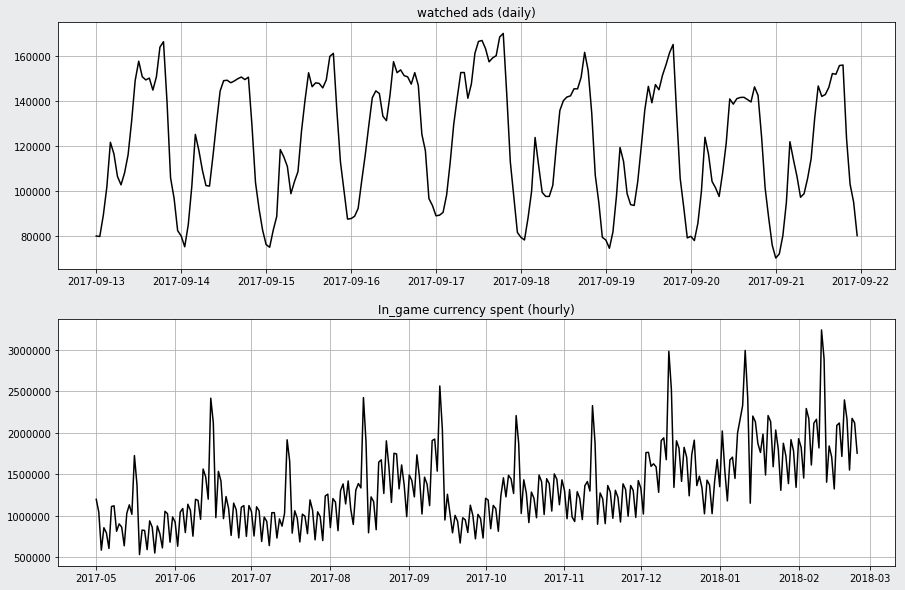

In [72]:
plt.figure(figsize=(15,10), facecolor='#eaebec')

plt.subplot(211)
plt.grid(True)
plt.title('watched ads (daily)')
plt.plot(ads.Ads, color='black')


plt.subplot(212)
plt.grid(True)
plt.plot(currency.GEMS_GEMS_SPENT, color='black')
plt.title('In_game currency spent (hourly)')

plt.show()

## Moving average

<p> Our motivation is a hypothesis: "tomorrow will be the same as today", which can be rephrased as<span style='color:red; font-family:serif; font-size:16px;'> the future value of our variable depends on the average of its $k$ previous values. </span></p>


Therefore we use the **moving average**


$$
\hat{y}_{t}=\sum_{n=1}^{k}{y_{t-n}}
$$



In [27]:
def moving_average(series, n):
    return np.average(series[-n:])

In [29]:
print(f'Prediction for the last 24 hours: {moving_average(ads, 24)}')
print(f'Prediction for the last 48 hours: {moving_average(ads, 48)}')
print(f'Prediction for the last 72 hours: {moving_average(ads, 72)}')
print(f'Prediction for the last 96 hours: {moving_average(ads, 96)}')
print(f'Prediction for the last 120 hours: {moving_average(ads, 120)}')

Prediction for the last 24 hours: 116805.0
Prediction for the last 48 hours: 116293.75
Prediction for the last 72 hours: 116908.26388888889
Prediction for the last 96 hours: 117163.02083333333
Prediction for the last 120 hours: 120824.16666666667


_Moving average_ is unable to make predictions far in the future. But it has another use case - **smoothing the original time series to identify trends**.

There is an implementation of the moving average in _Pandas_: `pandas.DataFrame.rolling(window).mean()`

Wider window ------> Smoother trend. If the data is very noisy (finances for example), moving average can help detect common patterns

In [41]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
    Description: Perform the plot of the moving average with pandas and matplotlib.pyplot.
        
    Arguments:
    -----------------------------------
        series : pandas.Series or pandas.DataFrame with pandas.Series.
                DataSeries to be plotted.
        window : int.
                Rolling window size. The wider is the window, the smoother is trend.
        scale  : float.
                Scalling multiplier
        plot_intervals : boolean, default : False. 
                Show confidence intervals.
        plot_anomalies : boolean, default : False. 
                Show anomalies in the time series.
    
    """
    # Find the moving average for the stated window with pandas implementation
    rolling_mean = series.rolling(window).mean()
    # Plot rolling mean, set the size of the figure and the title, add grid
    plt.figure(figsize=(15,5))
    plt.title(f'Moving average for the window of size {window} ')
    plt.grid()
    plt.plot(rolling_mean, c='g', label='Rolling mean trend')
    
    # Plot confidence intervals for smoothed values
    if plot_intervals:
        # Mean absolute error
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        # Set the deviation 
        deviation = np.std(series[window:] - rolling_mean[window:])
        # Set the lower and upper bonds
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        # Plot the upper and lower bonds
        plt.plot(upper_bound, 'r--', label = 'Upper Bond')
        plt.plot(lower_bound, 'r--', label = 'Lower Bond')
        
    # Find abnormal values (anomalies)
    if plot_anomalies:
        # Get the index and name of columns from the original series
        anomalies = pd.DataFrame(index=series.index, columns=series.columns)
        # Set all outbound values as abnormal
        anomalies[series < lower_bound] = series[series < lower_bound]
        anomalies[series > upper_bound] = series[series > upper_bound]
        # Plot the anomalies
        plt.plot(anomalies, 'ro', markersize=10)
    
    # Plot the actual values 
    plt.plot(series[window:], label='Actual values')
    # Place legend in the upper left corner
    plt.legend(loc='upper left')    

Smooth by the previous 2, 4, 8, 12, 24, 36 and 72 hours. With the previous 24 hours we get the daily trend

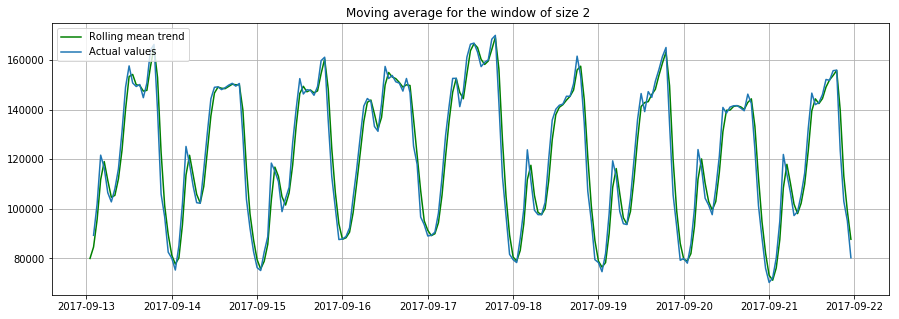

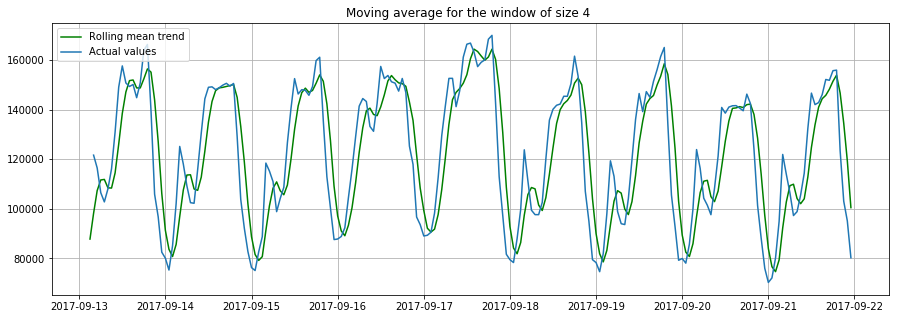

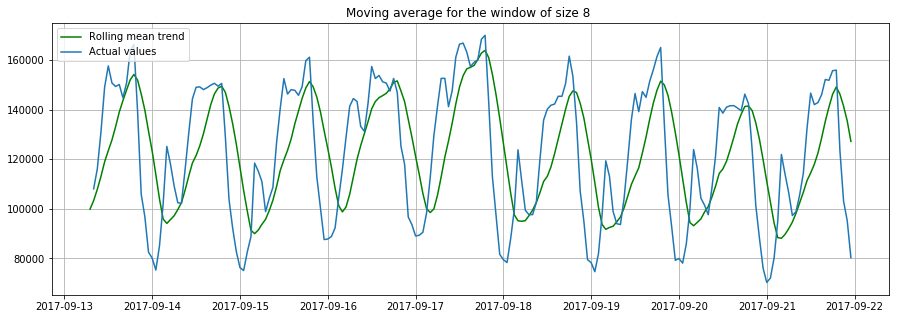

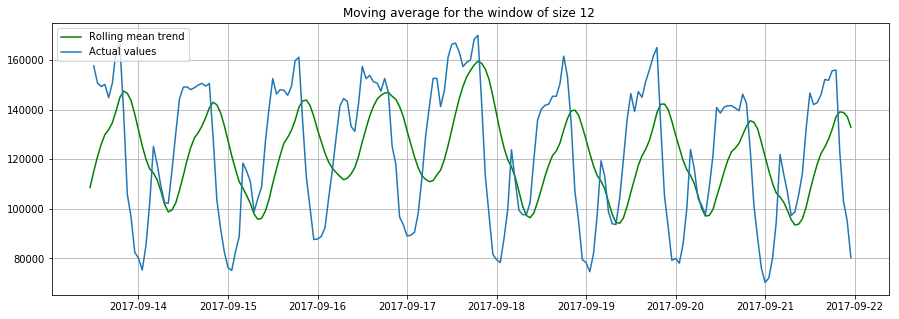

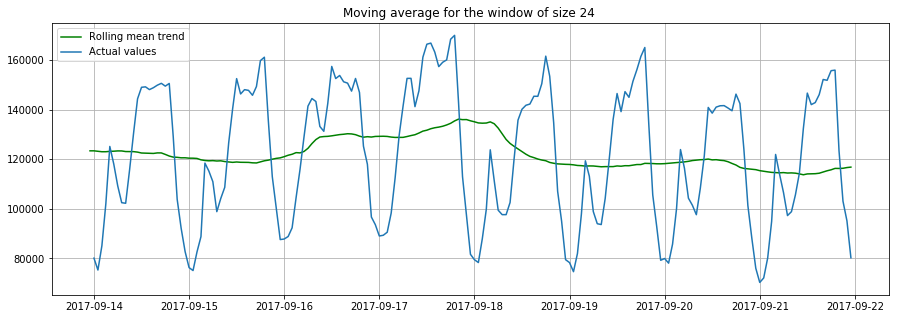

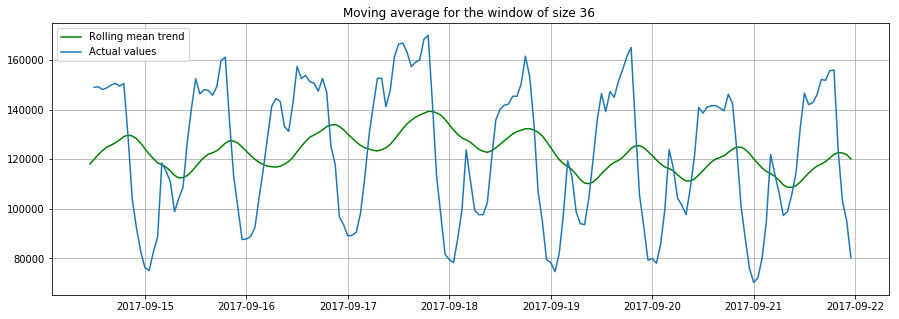

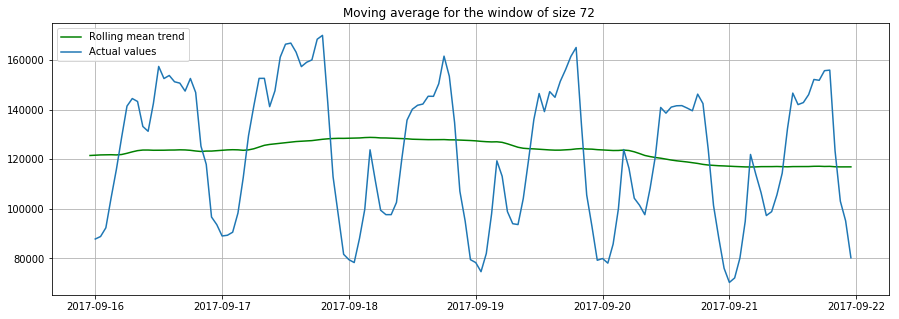

In [36]:
plot_moving_average(ads,2)
plot_moving_average(ads, 4)
plot_moving_average(ads, 8)
plot_moving_average(ads, 12)
plot_moving_average(ads, 24)
plot_moving_average(ads, 36)
plot_moving_average(ads, 72)
plt.show()

Plot the same, this time with intervals for our smoothed values

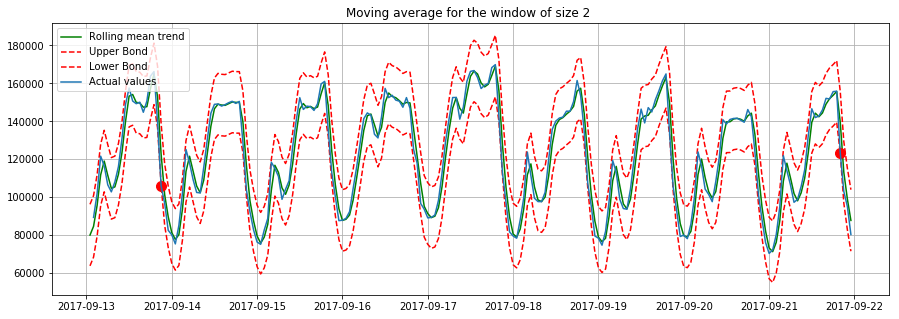

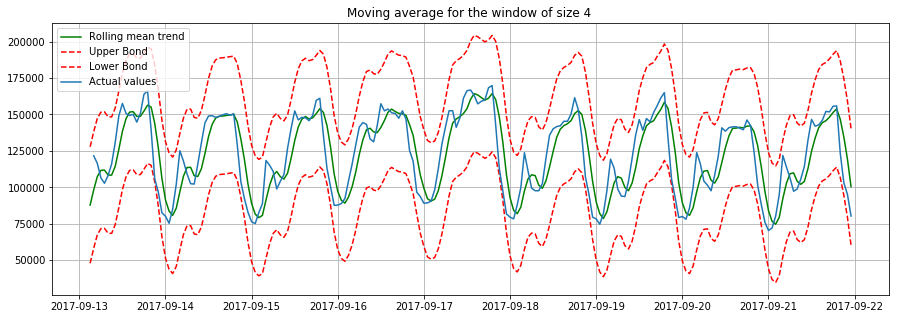

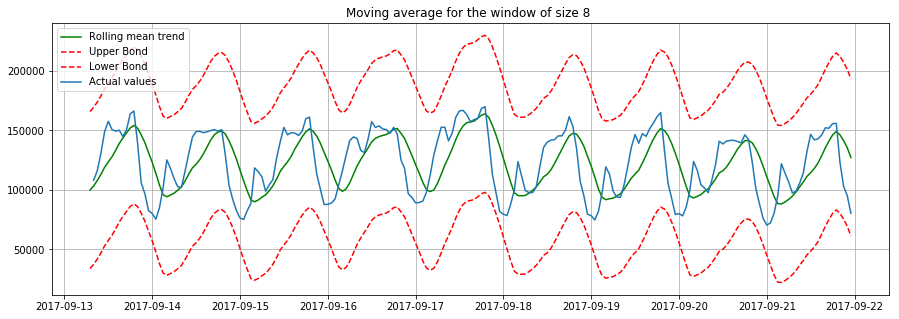

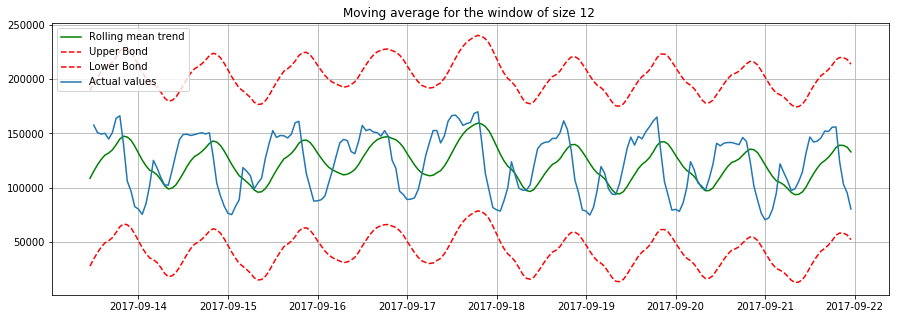

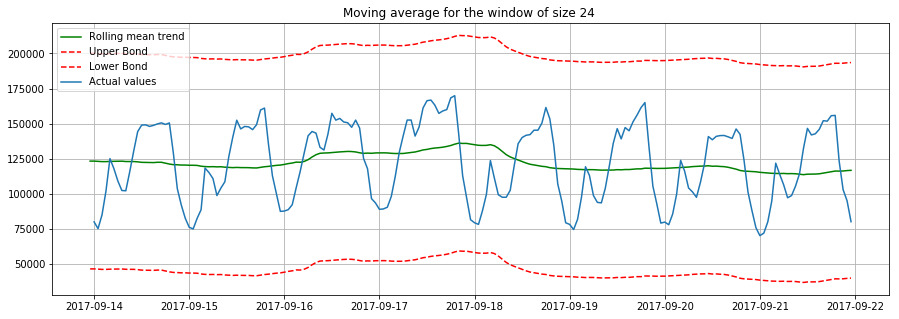

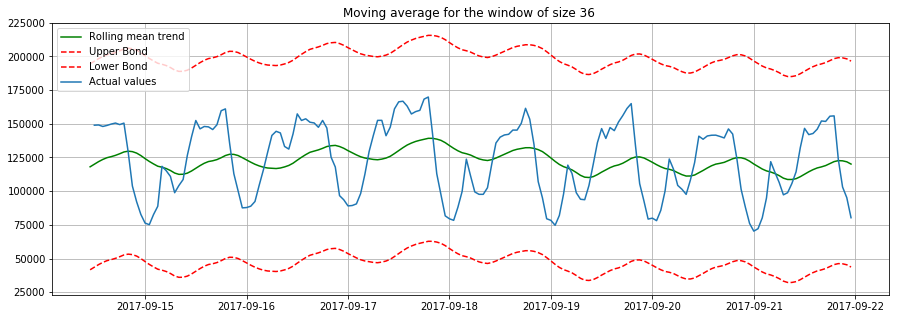

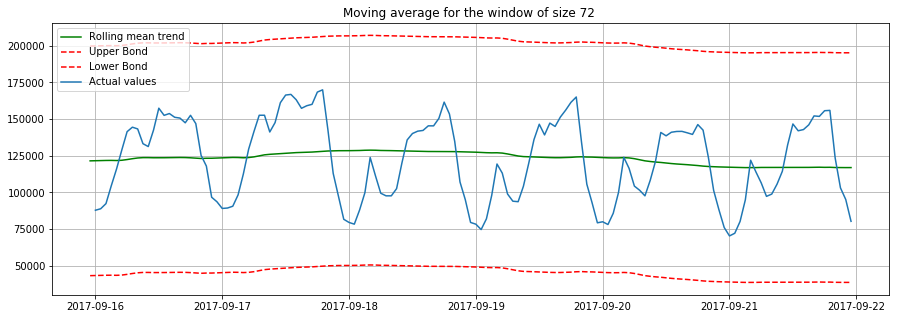

In [42]:
plot_moving_average(ads,2, plot_intervals=True, plot_anomalies=True)
plot_moving_average(ads, 4, plot_intervals=True, plot_anomalies=True)
plot_moving_average(ads, 8, plot_intervals=True, plot_anomalies=True)
plot_moving_average(ads, 12, plot_intervals=True, plot_anomalies=True)
plot_moving_average(ads, 24, plot_intervals=True, plot_anomalies=True)
plot_moving_average(ads, 36, plot_intervals=True, plot_anomalies=True)
plot_moving_average(ads, 72, plot_intervals=True, plot_anomalies=True)
plt.show()

Try plotting moving average for the currency

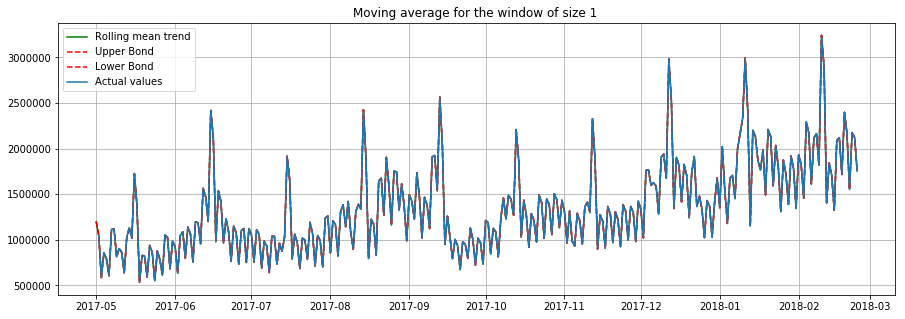

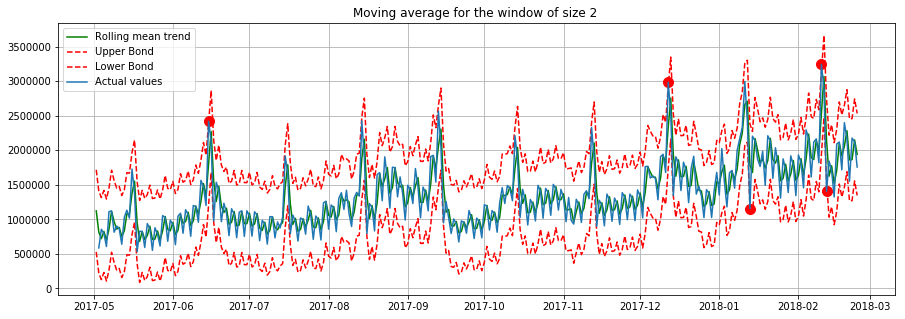

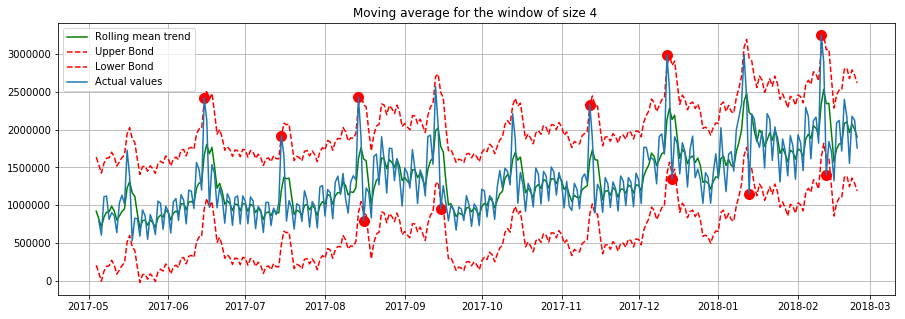

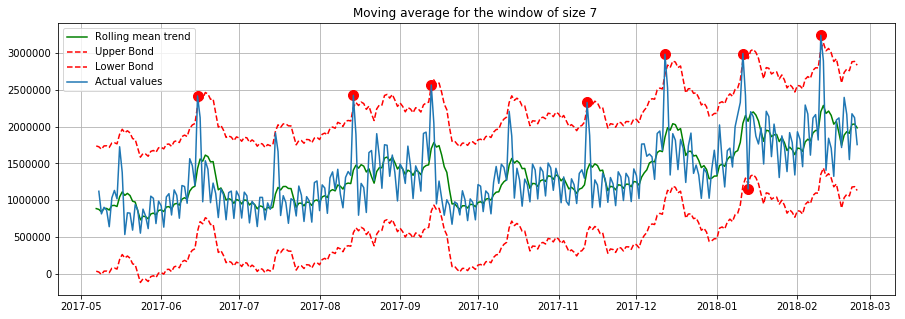

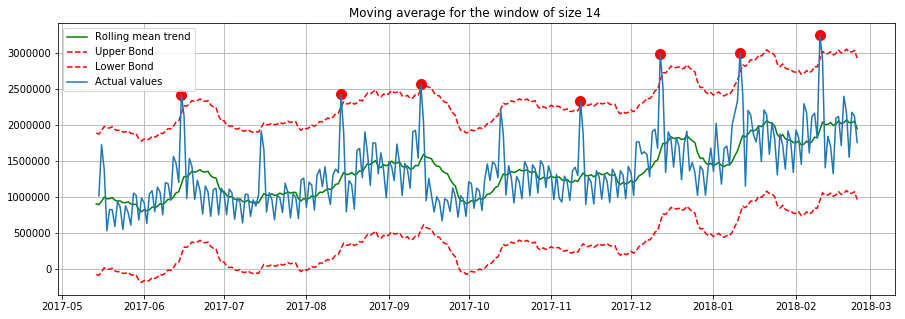

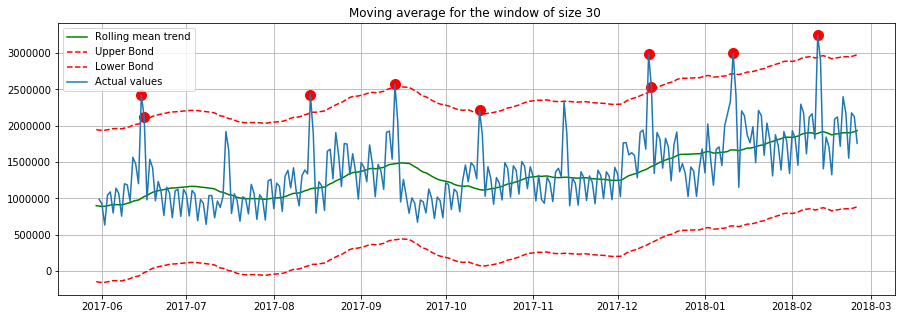

In [44]:
plot_moving_average(currency, 1, plot_intervals=True, plot_anomalies=True) 
plot_moving_average(currency, 2, plot_intervals=True, plot_anomalies=True) 
plot_moving_average(currency, 4, plot_intervals=True, plot_anomalies=True) 
plot_moving_average(currency, 7, plot_intervals=True, plot_anomalies=True)
plot_moving_average(currency, 14, plot_intervals=True, plot_anomalies=True)
plot_moving_average(currency, 30, plot_intervals=True, plot_anomalies=True) 

plt.show()

As we can see on the plot above, the moving average didn\`t capture the monthly seasonality in our data. Let\`s consider more complex approach to avoid false positives. 

## Weighted average

It is a simple modification of the moving average. The weights sum up to 1, larger weights are assigned to more recent observations.


$$
    \hat{y}_t = \sum_{n=1}^{k}{\omega_{n} y_{t+1-n}}
$$

In [57]:
def weighted_average(series, weights):
    """
    Description:
        Calculate weighted average on series.
        
    Arguments:
    ----------------------------------------------
        series : pandas.DataFrame or pandas.Series
        weights : list, tuple or any other iterable.
        
    Return:
        Weighted average on series of type 'float'
    """
    # Initialize a float
    result = 0.0
    # Reverse the list of weights
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

Check, if the weighted average computes well

In [60]:
weighted_average(ads, [0.6, 1.2, 0.1])

184062.5

## Exponential smoothing

Used if we start weighting all available observations instead the last $k$ observations.

Model value is a weighted average between the current true value and the previous model values:

$$
    \hat{y}_t = \alpha \cdot {y}_t + (1 - \alpha)\cdot \hat{y}_{t-1}
$$

$\alpha$ - smoothing factor. The larger the $\alpha$, the less influence previous observations have.

Function is exponential, because of recursion.  

In [63]:
def exponential_smoothing(series, alpha=0.3):
    """
        Description: Performs exponential smoothing for series.
                    Learn more about exponential smoothing: https://en.wikipedia.org/wiki/Exponential_smoothing
        
        Arguments:
        ----------------------------------------------
            series : pandas.DataFrame or pandas.Series
            alpha : float, default : 0.3
            
        Return: 
            Exponential smoothing for series with smoothing factor alpha
        
    """
    # First value should be the same as series
    result = [series[0]]
    # Range begins from 1, because the zeroth value is assigned above
    for n in range(1, len(series)):
        # Add new values
        result.append(alpha * series[n] + (1 - alpha) * result[-1])
    return result

Perform the plot for exponential smoothing

In [82]:
def plot_exponential_smoothing(series, alphas):
    """
        Description:
                Plots exponential smoothing with different smoothing factors.
                Requires import matplotlib.pyplot as plt
        Arguments:
        ----------------------------------------------
            series : pandas.DataFrame or pandas.Series.
                    x, y for the plot
            alphas : list, tuple or any iterable.
                   Array of floats, smoothing parameters
        
    """
    # Choose the style of plotting
    with plt.style.context('ggplot'): 
        # Plot the backgroung figure
        plt.figure(figsize=(15, 10))
        # Loop over the iterable of alphas to plot the line for every smoothing factor alpha
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        # Add legend, set the axis properties etc.
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

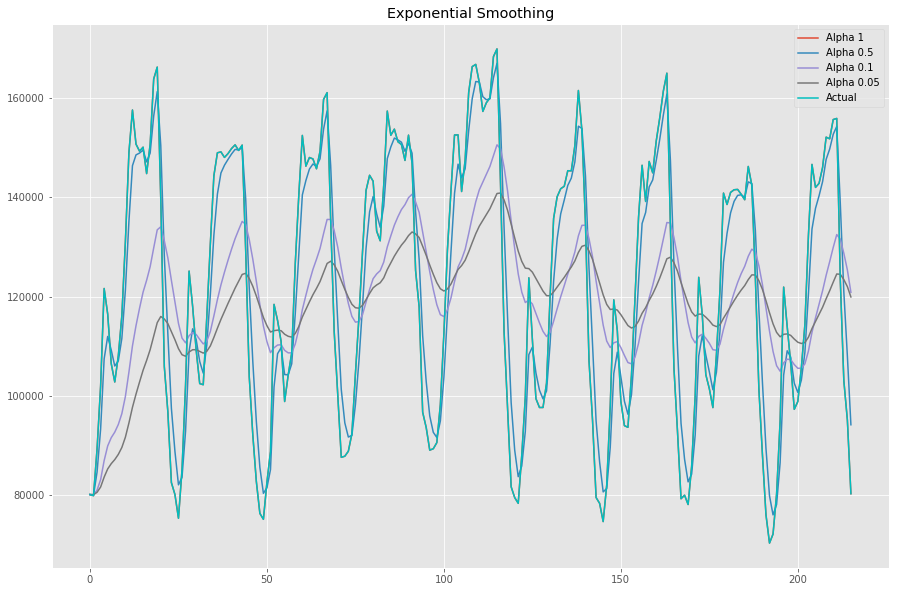

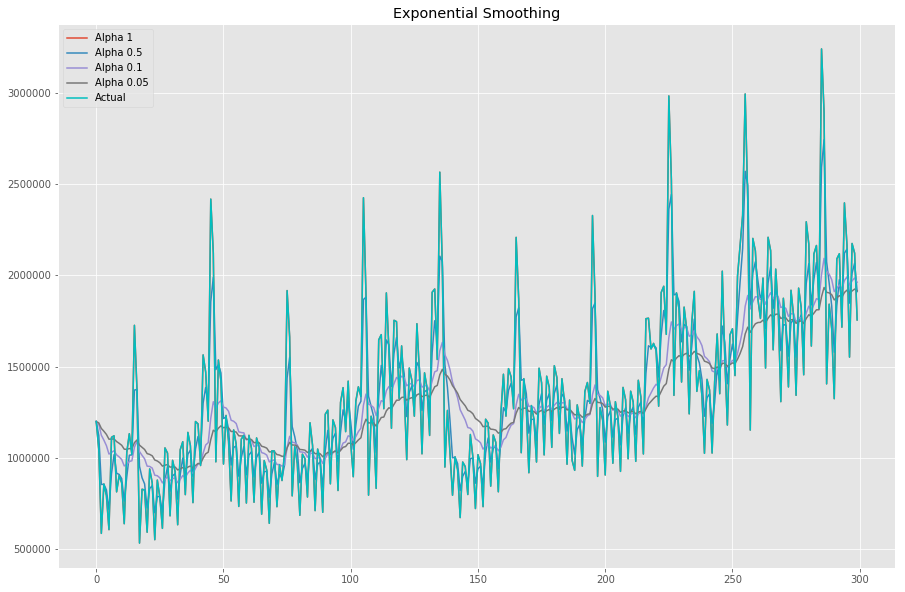

In [83]:
plot_exponential_smoothing(ads.Ads, [1,0.5,0.1, 0.05])
plot_exponential_smoothing(currency.GEMS_GEMS_SPENT,[1,0.5,0.1, 0.05])

## Double exponential smoothing

   
Methods, discussed above, work well for a single future point prediction with nice smoothing. Double exponential smoothing lets us predict two future points. To perform it, use the `series decomposition`: two components $l$ - intercept and $b$ - slope.

Apply the same as for level (intercept) exponential smoothing to the trend (slope), assuming that _`future direction of time series changes, depending on the previous weighted changes`_:



$$

    \hat{y}_{x+1} = l_{x} + b_{x}, where

    l_{x} = \alpha \cdot y_{x} + (1 - \alpha)(l_{x-1}+b_{x-1}) -- intercept, depends on the current value of the series.
    
    b_{x} = \beta \cdot (l_{x} - l_{x-1}) + (1 - \alpha)(l_{x-1} + b_{x-1}) -- slope, depends on the level changes at current step and on the previous trend value.
    
    \beta - weight for exponential smoothing

    
$$

In [85]:
def double_exponential_smoothing(series, alpha, beta):
    """
        Description:
            Perform double exponential smoothing as the sum of two parameters, describinh slope and intercept.
            
        Arguments:
        ----------------------------------------------
            series : pandas.DataFrame or pandas.Series.
                    Dataset with timeseries
            alpha  : float in range [0.0, 1.0]
                    Smoothing parameter for level (intercept)
            beta   : float in range [0.0, 1.0]
                    Smoothing parameter for trend (slope)
    
        Return : sum of the slope and intercept of type float
    """
    # First value should be the same as series
    result = [series[0]]
    # Loop over the series, omit the zeroth element, as it has been already included
    for n in range(1, len(series)+1):
        # Perform substraction
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        # Count the trend
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        # Count the slope
        trend = beta*(level-last_level) + (1-beta)*trend
        # Add level to trend
        result.append(level+trend)
    return result

Perform plotting

In [90]:
def plot_double_exponential_smoothing(series, alphas, betas):
    """
        Description:
            Plot the double exponential smoothing. Requires import matplotlib.pyplot
            
        Arguments:
        ----------------------------------------------
            series : pandas.DataFrame or pandas.Series.
                    Dataset with timeseries
            alpha  : 
                alpha should consist of floats in range [0.0, 1.0] only
            beta   : float in range [0.0, 1.0]
                beta should consist of floats in range [0.0, 1.0] only    
    """
    # Select a style
    with plt.style.context('seaborn-white'):
        # Create a figure
        plt.figure(figsize=(20, 10))
        # Loop over exponential smoothing parameters
        for alpha in alphas:
            for beta in betas:
                # Plot the double exponential smoothing for the actual value of trend and level.
                plt.plot(double_exponential_smoothing(series, alpha, beta), label=f'Intercept: {alpha}, Slope: {beta}')
        # Plot actual values of series, set legend, add title and grid
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

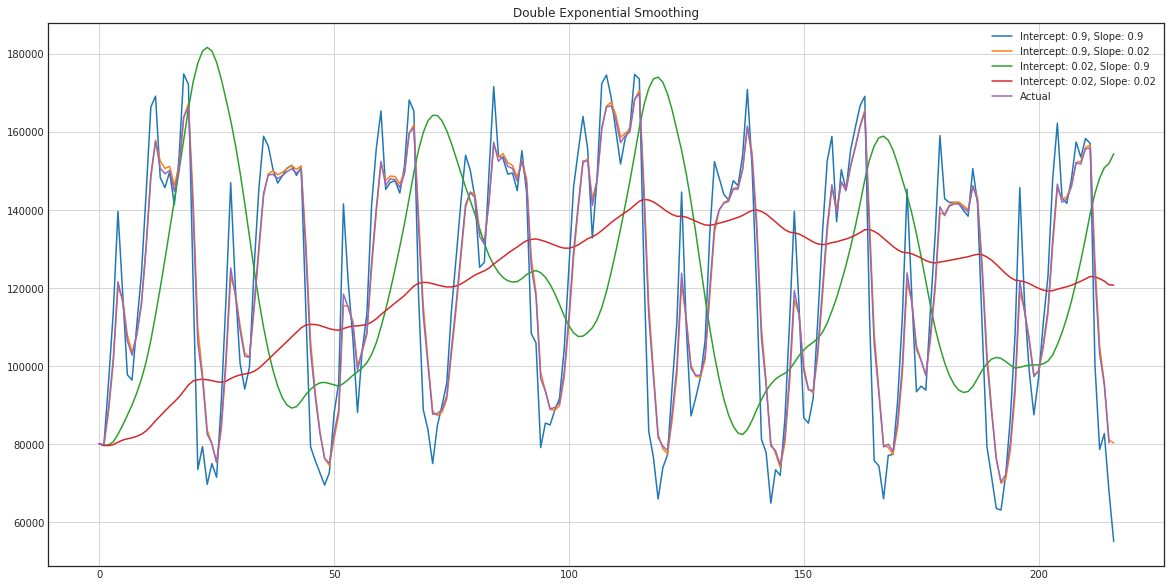

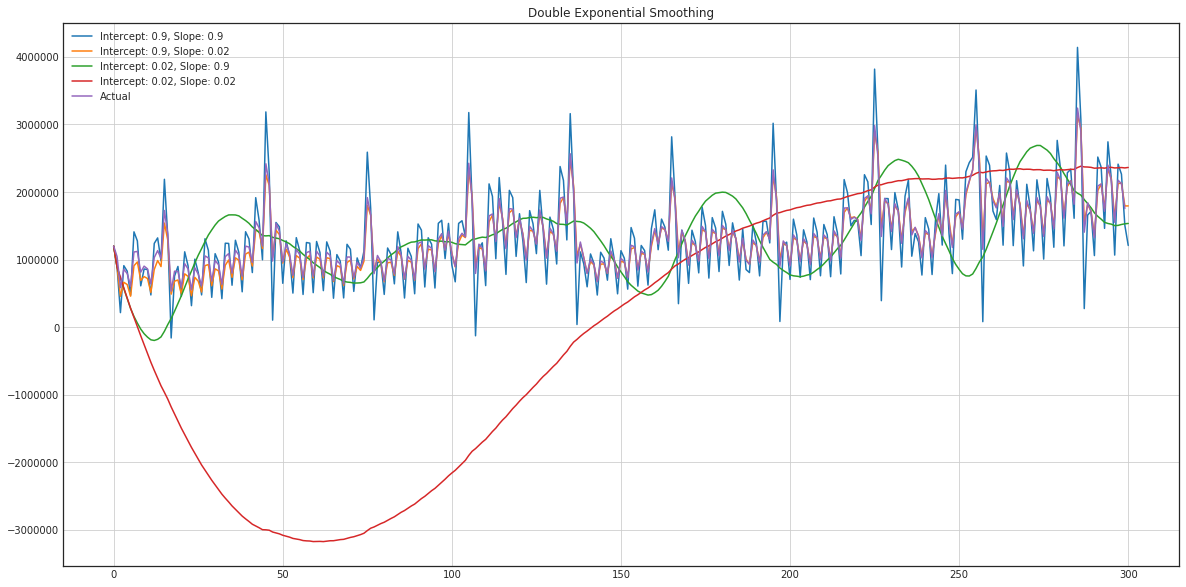

In [91]:
plot_double_exponential_smoothing(ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])
plot_double_exponential_smoothing(currency.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas=[0.9, 0.02])